In [1]:
!pip install yfinance
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 220.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 277.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=7c1831ed307c6af394ae399bdc4f547909c3e7dbb110558e7ea81dc48701e76c
  Stored in directory: /root/.cache/pip/wheels/7e/c3/40/fb36bba6c91caf81c39791388c71baca9635cbefd8e3bd48a7
Successfully built pandas_ta


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [3]:
data = yf.download('MSFT', start='2021-03-04', end='2022-03-04')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-04,226.740005,232.490005,224.259995,226.729996,222.713211,44727800
2021-03-05,229.520004,233.270004,226.460007,231.600006,227.496964,41872800
2021-03-08,231.369995,233.369995,227.130005,227.389999,223.361542,35267400
2021-03-09,232.880005,235.380005,231.669998,233.779999,229.638336,33080500
2021-03-10,237.000000,237.000000,232.039993,232.419998,228.302429,29746800
...,...,...,...,...,...,...
2022-02-25,295.140015,297.630005,291.649994,297.309998,294.421631,32546700
2022-02-28,294.309998,299.140015,293.000000,298.790009,295.887238,34627500
2022-03-01,296.399994,299.970001,292.149994,294.950012,292.084564,31217800


In [4]:
data = data[['Close']]
data

,Close
Date,
2021-03-04,226.729996
2021-03-05,231.600006
2021-03-08,227.389999
2021-03-09,233.779999
2021-03-10,232.419998
...,...
2022-02-25,297.309998
2022-02-28,298.790009
2022-03-01,294.950012


In [5]:
data.index

DatetimeIndex(['2021-03-04', '2021-03-05', '2021-03-08', '2021-03-09',
               '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-15',
               '2021-03-16', '2021-03-17',
               ...
               '2022-02-17', '2022-02-18', '2022-02-22', '2022-02-23',
               '2022-02-24', '2022-02-25', '2022-02-28', '2022-03-01',
               '2022-03-02', '2022-03-03'],
              dtype='datetime64[ns]', name='Date', length=253, freq=None)

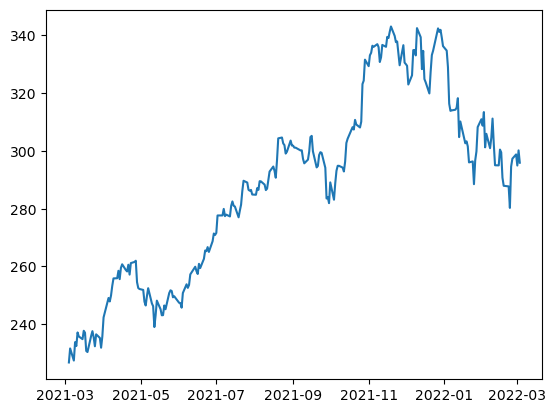

In [6]:
plt.plot(data.index, data['Close'])

Converting it to a supervised learning problem

In [7]:
def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Close'].shift(i)
    windowed_data['Target'] = data['Close']
    return windowed_data.dropna()

In [8]:
windowed_data = window_data(data, n=3)
windowed_data

,Target-3,Target-2,Target-1,Target
Date,,,,
2021-03-09,226.729996,231.600006,227.389999,233.779999
2021-03-10,231.600006,227.389999,233.779999,232.419998
2021-03-11,227.389999,233.779999,232.419998,237.130005
2021-03-12,233.779999,232.419998,237.130005,235.750000
2021-03-15,232.419998,237.130005,235.750000,234.809998
...,...,...,...,...
2022-02-25,287.720001,280.269989,294.589996,297.309998
2022-02-28,280.269989,294.589996,297.309998,298.790009
2022-03-01,294.589996,297.309998,298.790009,294.950012


In [9]:
dates = windowed_data.index.to_numpy()
X = windowed_data.drop(columns='Target')\
    .reset_index(drop=True)\
    .to_numpy().reshape(-1, 3, 1)
y = windowed_data['Target'].to_numpy()

In [10]:
# checking that the shapes are correct
dates.shape, X.shape, y.shape

((250,), (250, 3, 1), (250,))

Data Splitting

In [11]:
q80 = int(len(dates)*0.8)
q90 = int(len(dates)*0.9)

dates = {'train': dates[:q80], 'val': dates[q80:q90], 'test': dates[q90:]}
X = {'train': X[:q80], 'val': X[q80:q90], 'test': X[q90:]}
y = {'train': y[:q80], 'val': y[q80:q90], 'test': y[q90:]}

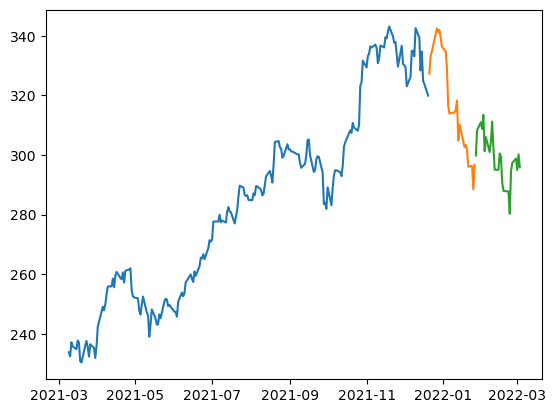

In [12]:
for split in ['train', 'val', 'test']:
    plt.plot(dates[split], y[split])

In [13]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [14]:
model.fit(X['train'], y['train'], epochs=100, validation_data=(X['val'], y['val']))

Epoch 1/100
7/7 [==============================] - 11s 175ms/step - loss: 81446.6797 - mean_absolute_error: 283.5647 - val_loss: 101470.4766 - val_mean_absolute_error: 318.1178
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 81305.9062 - mean_absolute_error: 283.3150 - val_loss: 101292.8672 - val_mean_absolute_error: 317.8385
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 81119.9062 - mean_absolute_error: 282.9884 - val_loss: 101030.6328 - val_mean_absolute_error: 317.4259
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 80885.4062 - mean_absolute_error: 282.5745 - val_loss: 100769.2031 - val_mean_absolute_error: 317.0136
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 80636.0703 - mean_absolute_error: 282.1298 - val_loss: 100430.1172 - val_mean_absolute_error: 316.4784
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 80270.7812 - mean_absolute_error: 281.4796 - val_lo

In [15]:
pred = {'train': model.predict(X['train']).flatten(),
        'val': model.predict(X['val']).flatten(),
        'test': model.predict(X['test']).flatten()}

1/1 [==============================] - 0s 30ms/step


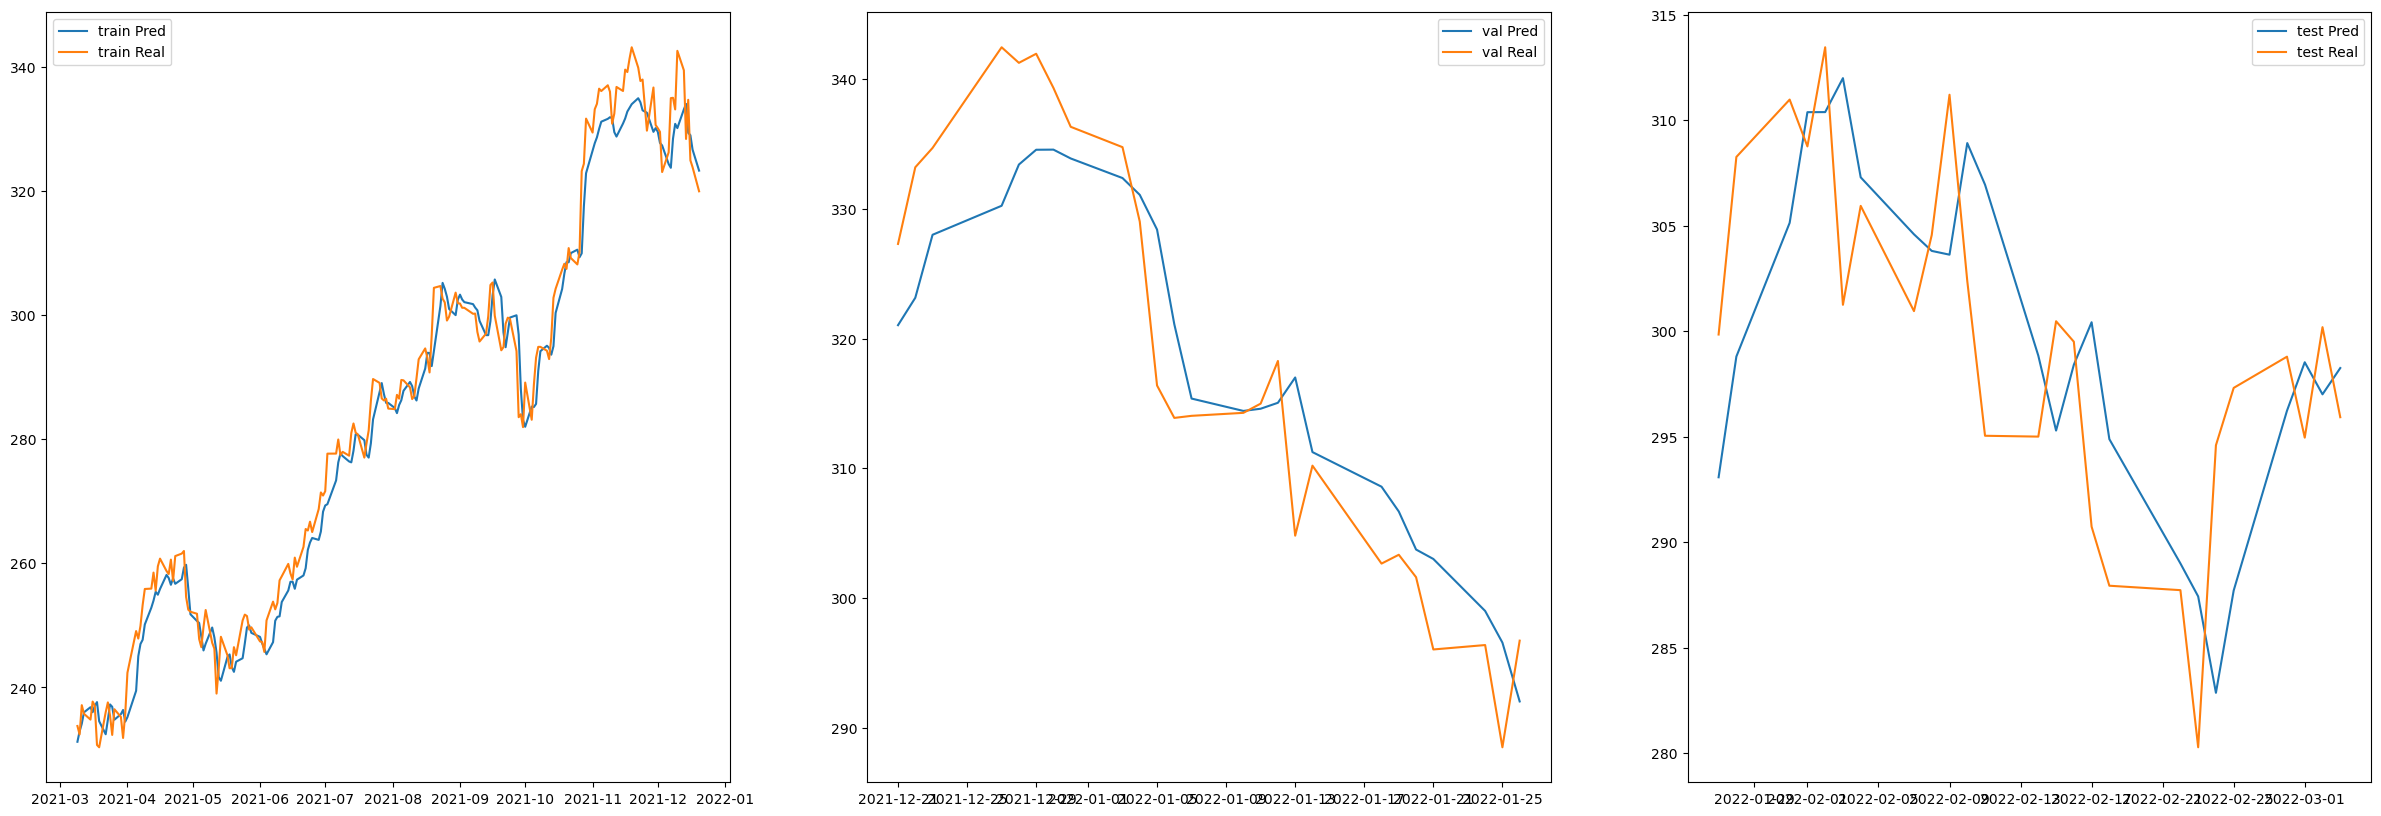

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))
for i, split in enumerate(['train', 'val', 'test']):
    ax[i].plot(dates[split], pred[split])
    ax[i].plot(dates[split], y[split])
    ax[i].legend([f'{split} Pred', f'{split} Real'])

plt.show()


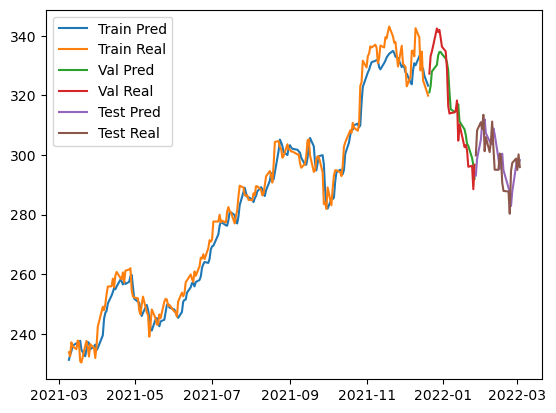

In [17]:
plt.plot(dates['train'], pred['train'])
plt.plot(dates['train'], y['train'])
plt.plot(dates['val'], pred['val'])
plt.plot(dates['val'], y['val'])
plt.plot(dates['test'], pred['test'])
plt.plot(dates['test'], y['test'])
plt.legend(['Train Pred', 
            'Train Real',
            'Val Pred', 
            'Val Real',
            'Test Pred', 
            'Test Real'])

In [18]:
from copy import deepcopy

seq_preds = []
seq_dates = np.concatenate([dates['val'], dates['test']])

last_window = deepcopy(X['train'][-1])
print(type(last_window[0]))
for target_date in seq_dates:
    next_pred = model.predict(np.array([last_window])).flatten()
    seq_preds.append(next_pred)
    
    # shifting the last window (ndarray sucks)
    for i in range(len(last_window)-1):
        last_window[i] = last_window[i+1]
    last_window[-1] = next_pred
    

<class 'numpy.ndarray'>
1/1 [==============================] - 0s 73ms/step


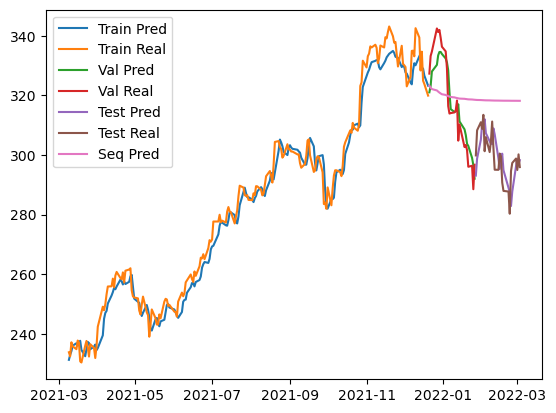

In [19]:
plt.plot(dates['train'], pred['train'])
plt.plot(dates['train'], y['train'])
plt.plot(dates['val'], pred['val'])
plt.plot(dates['val'], y['val'])
plt.plot(dates['test'], pred['test'])
plt.plot(dates['test'], y['test'])
plt.plot(seq_dates, seq_preds)
plt.legend(['Train Pred', 
            'Train Real',
            'Val Pred', 
            'Val Real',
            'Test Pred', 
            'Test Real',
           'Seq Pred'])

- On the recursive prediction - the model has no idea on how to predict in the far future. This is because it depends on previous predictions recursively, hence - the bias adds up.

- That does not mean that the model is useless, it works very well on the time intervals it was trained on.
